# Когортный анализ

![Когортный анализ](cohort.jpg "Когортный анализ")

## Что такое когортный анализ

**Когортный анализ** заключается в исследовании характеристик когорт/винтажей/поколений, объединенных по общим временным признакам. 

**Когорта/винтаж/поколение** — это группа, сформированная особым образом по временному признаку: например, месяцу регистрации, месяцу первой транзакции или первого посещения сайта.

Когорты очень похожи на сегменты с тем отличием, что когорта объединяет группы определенного промежутка времени, в то время как сегмент может быть основан на любых других характеристиках. Когорты позволяют анализировать тренды внутри метрики и отличать продуктовые метрики от метрик роста.

При построении когортного анализа важно учитывать взаимосвязь между событием или взаимодействием, которое вы отслеживаете, и его связь с вашей бизнес-моделью.

## Почему это ценно?

Когортный анализ может быть полезен, когда речь заходит о понимании здоровья вашего бизнеса и «липкости» - лояльности ваших клиентов. «Липкость» имеет решающее значение, так как гораздо дешевле и проще удерживать клиента, чем приобретать новый. 

Кроме того, ваш продукт развивается с течением времени. Новые функции добавляются и удаляются, измененяется дизайн и т. д. Наблюдение отдельных групп с течением времени является отправной точкой для понимания того, как эти изменения влияют на поведение пользователя/группы.

Это также хороший способ визуализировать удержание / отток пользователей, а также сформулировать базовое понимание их жизненного цикла.

## Применение

1. Анализ просрочки/ оценка периода созревания портфеля
2. Прогноз окупаемости рекламы
3. Измерение влияния ваших действий на продажи
4. Измерение здоровья бизнеса

## Анализ просрочки/ оценка периода созревания портфеля

В качестве примера на игрушечных данных, которые для демонстрации были дополнены записями о просрочке кредита, попробуем оценить период созревания (выхода на просрочку) портфеля по кредитам.

## Подгрузка пакетов и настройка notebook

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")

import seaborn as sns

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker
import matplotlib as mpl

pd.set_option('max_columns', 50)
mpl.rcParams['lines.linewidth'] = 2
%matplotlib inline

sns.set_context(
    "notebook", 
    font_scale = 1.5,       
    rc = { 
        "figure.figsize" : (30, 30), 
        "axes.titlesize" : 18 
    }
)

## Загрузка и подготовка данных

In [2]:
data = pd.read_csv('auto.csv', delimiter=";",decimal=".", encoding="windows-1251")

In [3]:
data.head()

,CreditDate,IIN,creditNumber,target
0,01.10.2016 9:40,000000-552800,51294,0
1,01.10.2016 9:46,000000-285780,51295,0
2,01.10.2016 9:56,000000-548720,51296,0
3,01.10.2016 10:22,000000-144841,51297,0
4,01.10.2016 10:17,000000-552800,51298,0


### Описание данных

1. creditNumber - ID заявки
2. IIN - ИИН клиента
3. CreditDate - Дата выдачи
4. target - признак - 1- просрочка, 0 - нет просрочки

### Создадим столбец периода на основе CreditDate

Поскольку мы делаем ежемесячные когорты, мы будем смотреть на общее ежемесячное поведение наших клиентов. Поэтому нам не нужны гранулированные данные CreditDate (прямо сейчас).

In [4]:
data['CreditDate'] = pd.to_datetime(data['CreditDate'],dayfirst=True)

In [6]:
data['CreditPeriod'] = data.CreditDate.apply(lambda x: x.strftime('%Y-%m'))

In [7]:
data.CreditPeriod.unique()

array(['2016-10', '2017-05', '2017-06', '2017-02', '2017-01', '2016-12',
       '2016-11', '2017-03', '2017-08', '2017-09', '2017-04', '2017-10',
       '2017-07'], dtype=object)

### Определите группу когорт (на основе даты их первого кредита)

Создадим новый столбец CohortGroup, который является годом и месяцем, когда произошла первая выдача кредита клиента.

In [8]:
data.set_index('IIN', inplace=True)

data['CohortGroup'] = data.groupby(level=0)['CreditDate'].min().apply(lambda x: x.strftime('%Y-%m'))

data.reset_index(inplace=True)

In [9]:
data.head()

,IIN,CreditDate,creditNumber,target,CreditPeriod,CohortGroup
0,000000-552800,2016-10-01 09:40:00,51294,0,2016-10,2016-10
1,000000-285780,2016-10-01 09:46:00,51295,0,2016-10,2016-10
2,000000-548720,2016-10-01 09:56:00,51296,0,2016-10,2016-10
3,000000-144841,2016-10-01 10:22:00,51297,0,2016-10,2016-10
4,000000-552800,2016-10-01 10:17:00,51298,0,2016-10,2016-10


### Накопительные данные CohortGroup & OrderPeriod

Поскольку мы рассматриваем ежемесячные когорты, нам необходимо агрегировать клиентов, кредиты и количество просрочек, допустивших CohortGroup в течение месяца (CreditPeriod).

In [10]:
grouped = data.groupby(['CohortGroup', 'CreditPeriod'])

cohorts = grouped.agg({'IIN': pd.Series.nunique,
                       'creditNumber': pd.Series.nunique,
                       'target': np.sum})

cohorts.rename(columns={'IIN': 'TotalClients',
                        'creditNumber': 'TotalOrders'}, inplace=True)

In [11]:
cohorts.head()

TotalClients  TotalOrders  target
CohortGroup CreditPeriod                                   
2016-10     2016-10               1008         1669     223
            2016-11                592          746     195
            2016-12                 22           26       6
            2017-01                 21           26       3
            2017-02                 28           35       3

### CohortPeriod для каждой группы CohortGroup

Мы хотим посмотреть, как каждая когорта вела себя в течение нескольких месяцев после их первого кредита, поэтому нам нужно будет проиндексировать каждую когорту до их первого месяца. Например, CohortPeriod = 1 будет первым месяцем когорты, CohortPeriod = 2 является их вторым и так далее.

Это позволяет нам сравнивать когорты на разных этапах их жизни.

In [12]:
def cohort_period(df):
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

TotalClients  TotalOrders  target  CohortPeriod
CohortGroup CreditPeriod                                                 
2016-10     2016-10               1008         1669     223             1
            2016-11                592          746     195             2
            2016-12                 22           26       6             3
            2017-01                 21           26       3             4
            2017-02                 28           35       3             5

### Период созревания кредитов

Мы хотим посмотреть процентное изменение каждой CohortGroup с течением времени, а не абсолютное изменение.

Для этого нам сначала нужно создать серию pandas, содержащую каждую CohortGroup и ее размер.

In [13]:
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

cohort_group_size = cohorts['target'].groupby(level=0).first()
cohort_group_size.head(100)

CohortGroup
2016-10    223
2016-11    185
2016-12    287
2017-01    181
2017-02    108
2017-03      5
2017-04     94
2017-05    131
2017-06     50
2017-07    103
2017-08     50
2017-09     54
2017-10      0
Name: target, dtype: int64

Теперь нам нужно разделить значения target в когортах с помощью cohort_group_size. Поскольку операции DataFrame выполняются на основе индексов объектов, мы будем использовать unack в наших когортах DataFrame для создания матрицы, в которой каждый столбец представляет CohortGroup, и каждая строка является CohortPeriod, соответствующей этой группе.

Чтобы проиллюстрировать, что делает откат, вспомним первые пять значений target:

In [14]:
cohorts['target'].head()

CohortGroup  CohortPeriod
2016-10      1               223
             2               195
             3                 6
             4                 3
             5                 3
Name: target, dtype: int64

Вот как они выглядят, когда мы снимаем уровень CohortGroup из индекса:

In [15]:
cohorts['target'].unstack(0).head()

CohortGroup,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10
CohortPeriod,,,,,,,,,,,,,
1,223.0,185.0,287.0,181.0,108.0,5.0,94.0,131.0,50.0,103.0,50.0,54.0,0.0
2,195.0,18.0,8.0,4.0,0.0,0.0,8.0,7.0,1.0,5.0,1.0,NaN,NaN
3,6.0,4.0,5.0,0.0,3.0,0.0,5.0,2.0,2.0,3.0,NaN,NaN,NaN
4,3.0,2.0,0.0,3.0,4.0,1.0,5.0,2.0,1.0,NaN,NaN,NaN,NaN
5,3.0,2.0,1.0,2.0,2.0,0.0,1.0,3.0,NaN,NaN,NaN,NaN,NaN


Теперь мы можем использовать разделить каждый столбец на соответствующий cohort_group_size.

Полученный DataFrame, npl, содержит процент  просроченных договоров от договоров когорты в течение данного периода. Например, 26,9% договоров в 2016-10 году вышли на просрочку на 3-м месяце (который будет в декабре 2016 года).

In [17]:
npl = cohorts['target'].unstack(0).divide(cohort_group_size, axis=1)
npl.head(100)

CohortGroup,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10
CohortPeriod,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.00,1.000000,1.00,1.0,NaN
2,0.874439,0.097297,0.027875,0.022099,0.000000,0.0,0.085106,0.053435,0.02,0.048544,0.02,NaN,NaN
3,0.026906,0.021622,0.017422,0.000000,0.027778,0.0,0.053191,0.015267,0.04,0.029126,NaN,NaN,NaN
4,0.013453,0.010811,0.000000,0.016575,0.037037,0.2,0.053191,0.015267,0.02,NaN,NaN,NaN,NaN
5,0.013453,0.010811,0.003484,0.011050,0.018519,0.0,0.010638,0.022901,NaN,NaN,NaN,NaN,NaN
6,0.461883,0.000000,0.010453,0.011050,0.037037,0.0,0.021277,NaN,NaN,NaN,NaN,NaN,NaN
7,0.022422,0.032432,0.006969,0.005525,0.018519,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,0.040359,0.021622,0.010453,0.011050,0.027778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0.327354,0.021622,0.017422,0.005525,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Наконец, мы можем сгруппировать когорты с течением времени, чтобы выявить поведенческие различия или сходства. Две общие когортные диаграммы - это линейные графики и диаграммы направленности, оба из которых показаны ниже.

Обратите внимание, что первый период каждой когорты составляет 100% - это связано с тем, что наши когорты основаны на первой выдаче каждого клиента, то есть каждый в когорте, приобретенной в месяц 1.

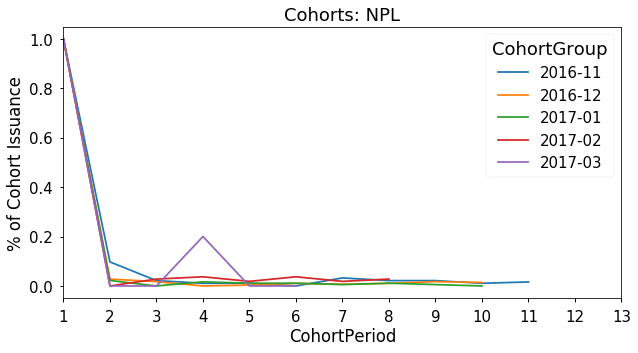

In [20]:
npl[['2016-11','2016-12','2017-01','2017-02','2017-03']].plot(figsize=(10,5))
plt.title('Cohorts: NPL')
plt.xticks(np.arange(1, 13.1, 1))
plt.xlim(1, 13)
plt.ylabel('% of Cohort Issuance');

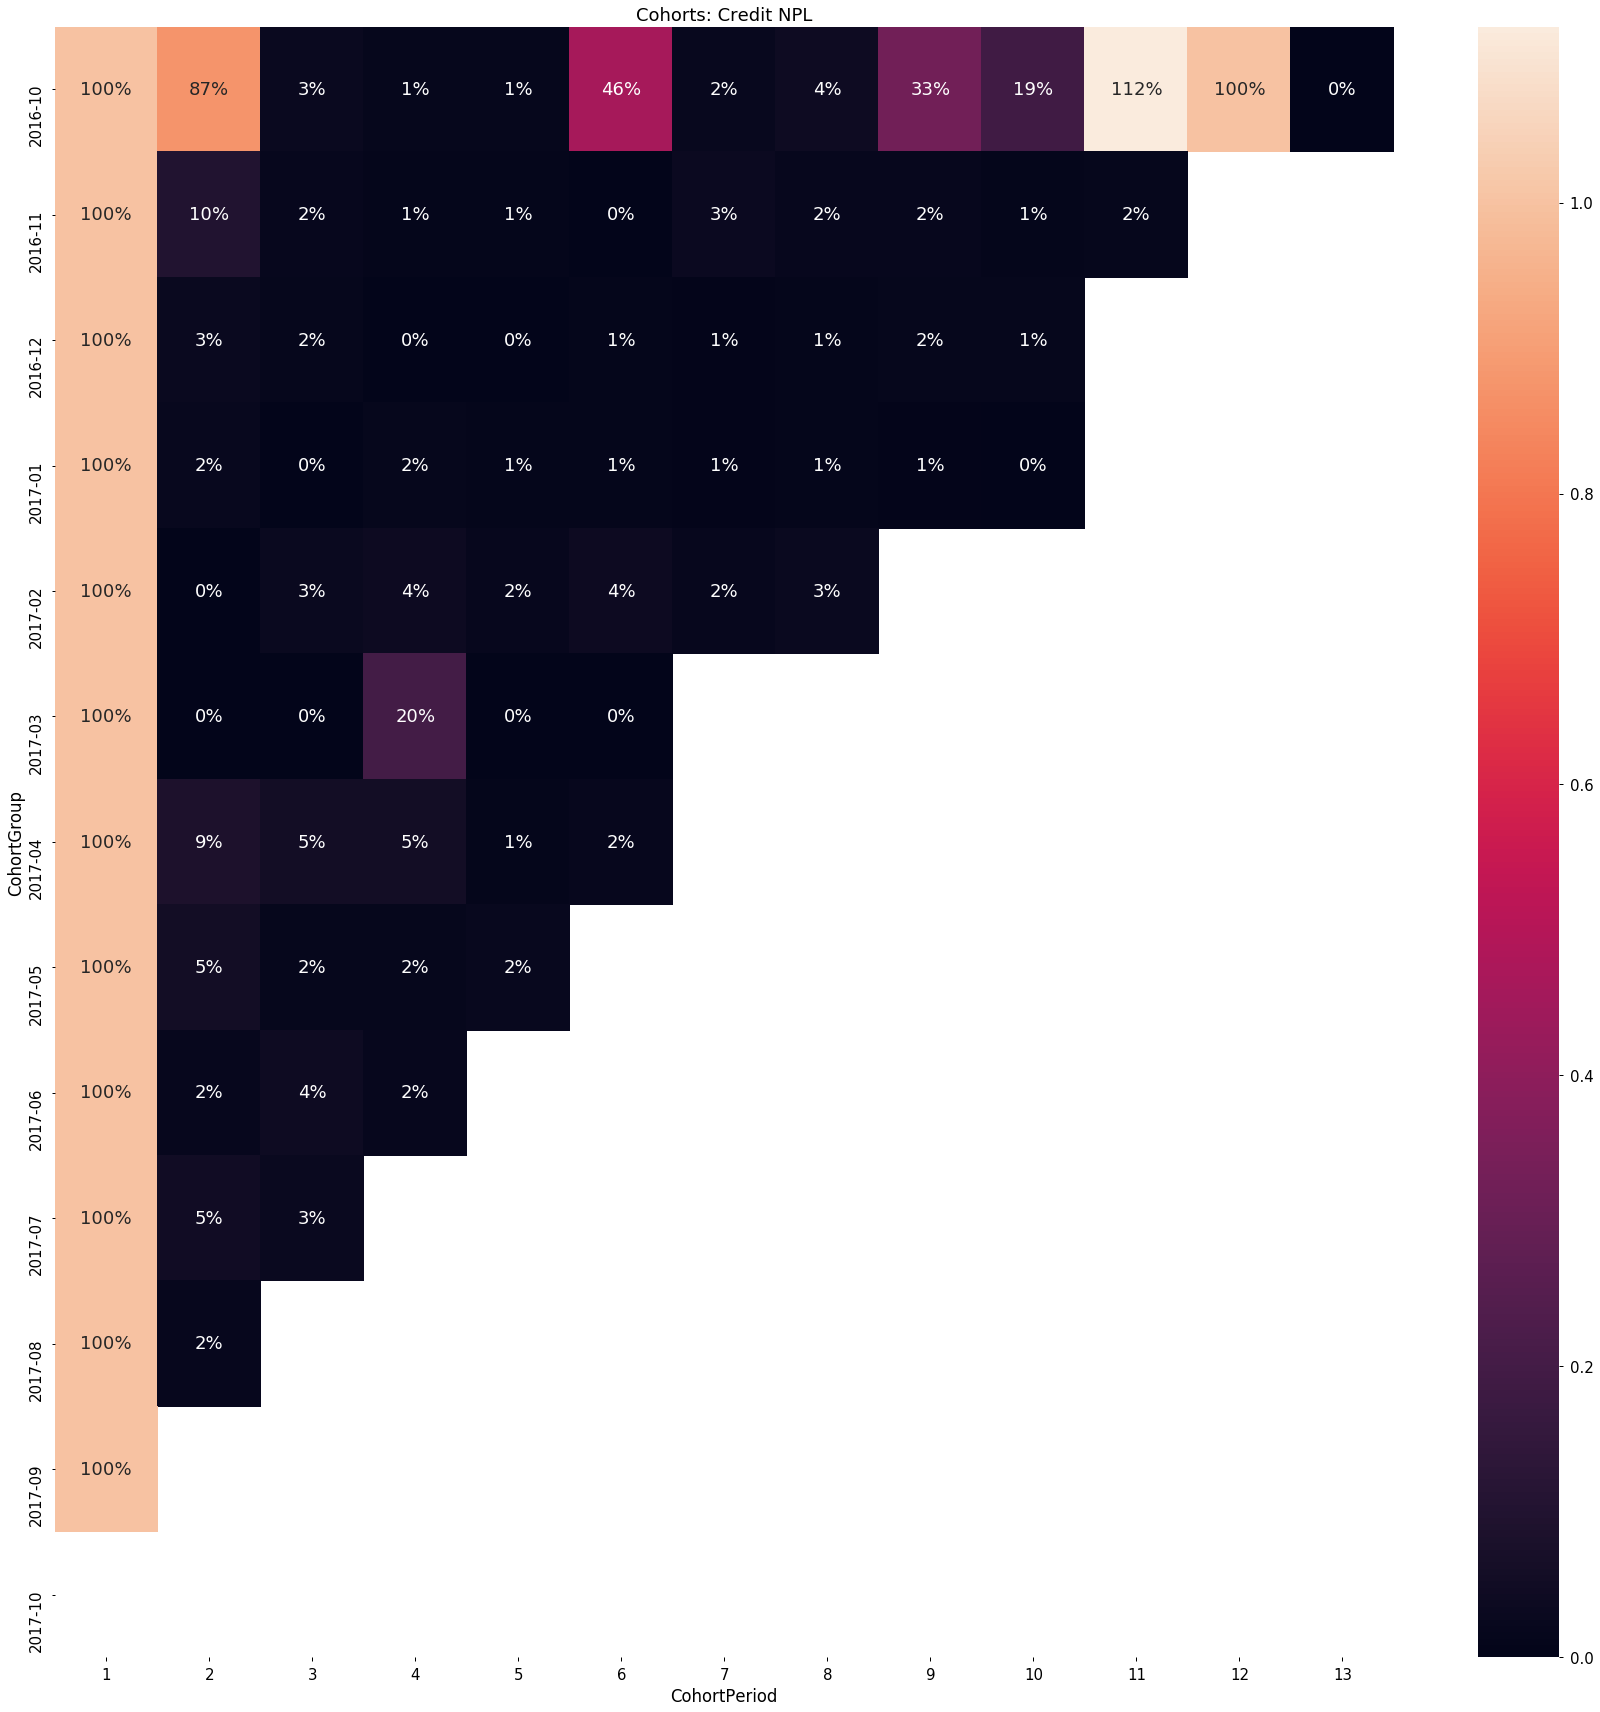

In [21]:
plt.figure(figsize=(30, 30))
plt.title('Cohorts: Credit NPL')
sns.heatmap(npl.T, mask=npl.T.isnull(), annot=True, fmt='.0%');

Из приведенной выше диаграммы видно, что меньшее количество договоров, как правило, выходит на просрочку с течением времени.

Тем не менее, мы также можем видеть, что когорта 2016-10 является самой сильной, что позволяет нам задавать целенаправленные вопросы об этой когорте по сравнению с другими - какие другие атрибуты (помимо первого месяца выдачи) разделяют эти договора, что может привести к их просрочке? Как большинство этих договоров были выданы? Была ли проведена определенная маркетинговая кампания? Получали ли они участие в акции? Ответы на эти вопросы будут полезны для будущих маркетинговых и продуктовых мероприятий.

## Вывод о периоде созревания просрочки

Основываясь на данных мы видим, что в основом просрочка созревает на 2-3 месяц после выдачи кредита. Но в 6 когорте период созревания наступил на 4 месяц. Этот факт интересен и требует дополнительного изучения.